In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

# Clustering Songs by Mood -- Spotify dataset

The aim of this exercise is to cluster a Spotify songs dataset by their mood. For that, we will use some features associated with each song.  Some of the features linked to mood that we want to consider are: 

- Energy: measure intensity and activity of a track, less energy score means is less energetic.
- Valence: positivity of the track, more valence score means is sound positive (happy, joy, cheerful).
- Danceability: how suitable a track is for dancing (0: least danceable, 1: most danceable).
- Tempo: Speed of the song, measured in beats per minute (BPM).
- Acousticness: measures whether the track is acoustic, 1 represent high confidence the track is acoustic
- Instrumentalness: measures the likelihood of a track containing vocals, a high score means the track is likely instrumental
- Loudness: the overall loudness of a track in decibels (dB)

We will consider clustering using K-Means and DBSCAN.

In [2]:
# Load the data
data = pd.read_csv('SpotifyFeatures.csv')
data.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [3]:
# If there are duplicated songs in the dataset, let's remove it
duplicate_mask = data.duplicated(subset='track_id', keep='first')
duplicates = data[duplicate_mask]
data = data.drop_duplicates(subset='track_id', keep='first')

print("Removed {} duplicate songs.".format(len(duplicates)))

Removed 55951 duplicate songs.


In [4]:
# Let's also remove some columns that are not useful for our exercise 
data.drop(['artist_name', 'track_name', 'track_id'], 
          axis=1, inplace=True)
data.head()

,genre,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


Some clustering algorithms (e.g. K-Means) are sensitive to scale. Let's normalize the features:

In [5]:
# Only numerical columns will be normalized
num_cols = data.select_dtypes(include='number').columns

scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])
data.head()

,genre,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,-2.085747,0.564740,-0.798733,-1.047822,1.279646,-0.532841,C#,0.575611,1.299283,Major,-0.366515,1.588677,4/4,1.353170
1,Movie,-2.028246,-0.431708,0.257016,-0.756663,0.652467,-0.532841,F#,-0.348444,0.715907,Minor,-0.198661,1.813226,4/4,1.360637
2,Movie,-1.913244,1.495668,0.640447,-0.504626,-1.544471,-0.532841,C,-0.575904,-0.585001,Minor,-0.446282,-0.565544,5/4,-0.312134
3,Movie,-2.085747,0.815900,-1.581352,-0.641318,-0.837536,-0.532841,C#,-0.597228,-0.319034,Major,-0.430133,1.741558,4/4,-0.838608
4,Movie,-1.855743,1.490208,-1.103376,-1.176146,-1.203692,-0.151959,F,-0.106768,-1.721889,Major,-0.400281,0.746124,4/4,-0.229989


Let's take a look in the correlation matrix:

<Axes: title={'center': 'Correlation Matrix'}>

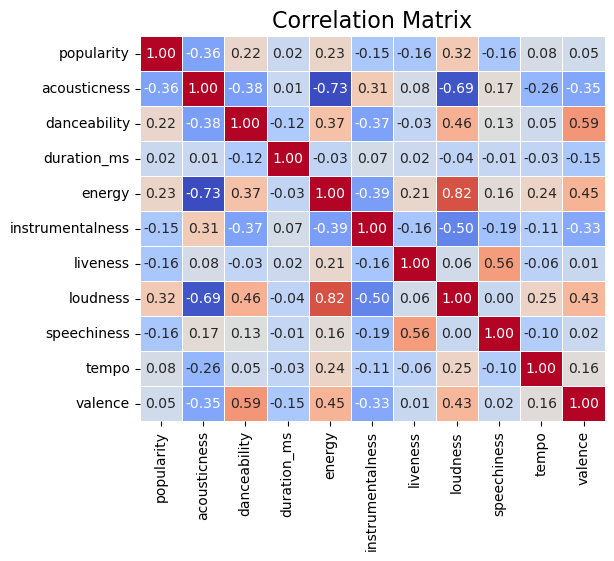

In [6]:
corr_matrix = data.select_dtypes(include='number').corr()

plt.figure(figsize=(6, 5))
plt.title('Correlation Matrix', fontsize=16)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, 
            xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns, cbar=False)

Let's take a moment and analize the correlation matrix. It is posible to see that:

- energy has highly negative correlations to acousticness, and positive to valence and loudness
- acousticness has highly negative correlation to loudness

Make sense!

### Encoding of categorial variables

Before proceeding, we also want to convert non-numeric data into a numeric format so features like genre, key, mode and time signature can be added to the clustering method.

In [7]:
for col in data.columns:
    if data[col].dtype == 'object':
        frequency_map = data[col].value_counts(normalize=True)
        data[col+'_encoded'] = data[col].map(frequency_map)
        
# Let's keep the enconded features and remove their original columns
object_cols = data.select_dtypes(include='object').columns
data = data.drop(object_cols, axis=1)

data.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,genre_encoded,key_encoded,mode_encoded,time_signature_encoded
0,-2.085747,0.564740,-0.798733,-1.047822,1.279646,-0.532841,0.575611,1.299283,-0.366515,1.588677,1.353170,0.044135,0.095353,0.659707,0.843942
1,-2.028246,-0.431708,0.257016,-0.756663,0.652467,-0.532841,-0.348444,0.715907,-0.198661,1.813226,1.360637,0.044135,0.064291,0.340293,0.843942
2,-1.913244,1.495668,0.640447,-0.504626,-1.544471,-0.532841,-0.575904,-0.585001,-0.446282,-0.565544,-0.312134,0.044135,0.118626,0.340293,0.025060
3,-2.085747,0.815900,-1.581352,-0.641318,-0.837536,-0.532841,-0.597228,-0.319034,-0.430133,1.741558,-0.838608,0.044135,0.095353,0.659707,0.843942
4,-1.855743,1.490208,-1.103376,-1.176146,-1.203692,-0.151959,-0.106768,-1.721889,-0.400281,0.746124,-0.229989,0.044135,0.088277,0.659707,0.843942


## K Means

K-means is a clustering algorithm that groups data points by assigning each one to the nearest "centroid," which is the center of a cluster. The algorithm adjusts the centroids step by step to make the clusters as tight and distinct as possible.

To use K-means, you need to choose the number of clusters (k) in advance. A common way to decide the number of clusters is the Elbow method, which involves testing different values of k and plotting how well the data fits the clusters. The "elbow" in the plot shows the best number of clusters, where adding more doesn't improve the fit much.

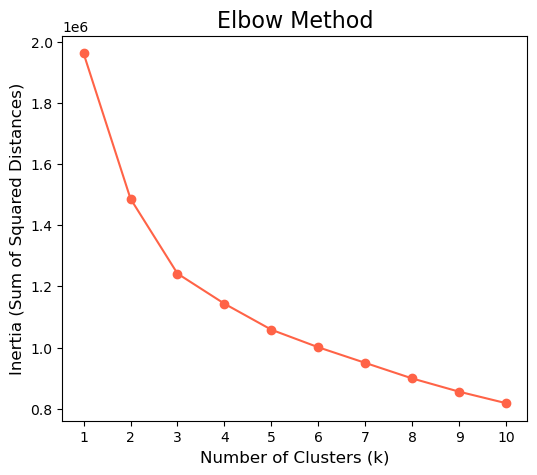

In [8]:
k_values = range(1, 11)

inertia = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6, 5))
plt.plot(k_values, inertia, marker='o', linestyle='-', color='tomato')
plt.title('Elbow Method', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Sum of Squared Distances)', fontsize=12)
plt.xticks(k_values)
plt.show()

We can see that there is a pseudo elbow between 2 and 4 clusters. Let's choose 3 for our exercise.

In [9]:
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model to the data
kmeans.fit(data)

# Get cluster labels for each data point
cluster_labels = kmeans.labels_

# Add cluster labels to the DataFrame
data['mood_label'] = cluster_labels

Now, we can assess the clustering quality. For that, we can use the Calinski-Harabasz, also known as the Variance Ratio Criterion. This metric considers the ratio of the variance between clusters to the variance within clusters. A higher value indicates better-defined and well-separated clusters.

In [10]:
calinski_harabasz_index = calinski_harabasz_score(data, cluster_labels)
print("Calinski-Harabasz Index:", calinski_harabasz_index)

Calinski-Harabasz Index: 54707.08086167825


Let's check some cluster features:

In [11]:
cluster_summary = data.groupby('mood_label')[['energy', 'valence', 'danceability', 'tempo', 'speechiness', 
                                      'acousticness', 'instrumentalness', 'loudness']].mean()
print(cluster_summary)

              energy   valence  danceability     tempo  speechiness  \
mood_label                                                            
0          -1.292959 -0.887845     -0.989422 -0.373234    -0.373460   
1           0.444381  0.337759      0.354680  0.188334    -0.167805   
2           0.370180 -0.133301      0.109540 -0.606695     3.625727   

            acousticness  instrumentalness  loudness  
mood_label                                            
0               1.180101          0.915461 -1.247754  
1              -0.523331         -0.292237  0.483840  
2               1.061036         -0.528250 -0.296191  


The clusters can be described as:

- Cluster 0: Chill or Melancholic (low energy, low valence, low danceability)
- Cluster 1: Happy or Dance/Party (high energy, high valence, high denceability)
- Cluster 2: Introspective or Emotional (moderate energy, low valence, high acousticness)

Now, let's visualize the clusters using PCA and t-SNE.

### PCA 

Here, we use dimensionality reduction PCA to project the data and plot clusters.

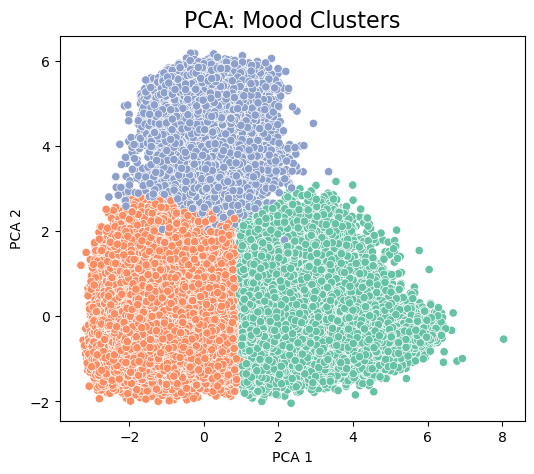

In [13]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)
data_pca = pd.DataFrame(X_pca, columns=['PCA 1', 'PCA 2'])
data_pca['mood_label'] = cluster_labels

plt.figure(figsize=(6, 5))
sns.scatterplot(data=data_pca, x='PCA 1', y='PCA 2', hue='mood_label', palette='Set2', legend=False)
plt.title('PCA: Mood Clusters', fontsize=16)
plt.show()

### t-SNE

In the case of t-SNE, some key parameters need to be set: 

- perplexity: Balances local vs. global aspects of the data.
- learning_rate: Controls the step size.
- n_iter: Number of iterations. Higher values yield better separation at the cost of computation time.

In [14]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200, n_iter=500)
X_tsne = tsne.fit_transform(data)

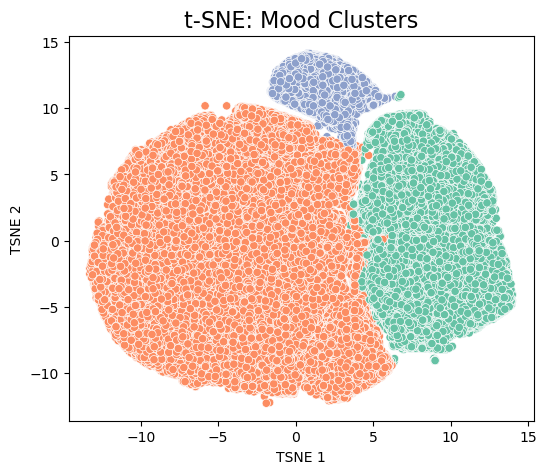

In [15]:
data_tsne = pd.DataFrame(X_tsne, columns=['TSNE 1', 'TSNE 2'])
data_tsne['mood_label'] = cluster_labels

plt.figure(figsize=(6, 5))
sns.scatterplot(data=data_tsne, x='TSNE 1', y='TSNE 2', hue='mood_label', palette='Set2', legend=False)
plt.title('t-SNE: Mood Clusters', fontsize=16)
plt.show()

## DBSCAN

DBSCAN uses a reachability distance concept to identify clusters of densely packed points while treating points in sparse regions as outliers or noise. It is effective at finding clusters of arbitrary shapes and is robust to noise in the data.

The key parameters are:
- eps: The maximum distance between two points for them to be considered part of the same neighborhood. It defines the radius of a cluster.
- min_samples: The minimum number of points required to form a dense region. Points with fewer neighbors are classified as noise unless they belong to a cluster.

Here, we applied DBSCAN after the dimensionality reduction with PCA to simplify the structure and improve clustering performance.

In [16]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters_db = dbscan.fit_predict(data_pca)
data_pca['mood_label_db'] = clusters_db

n_clusters = len(set(clusters_db)) - (1 if -1 in clusters_db else 0)
n_noise = list(clusters_db).count(-1)

print("Estimated number of clusters:",n_clusters)
print("Estimated number of noise points:",n_noise)

Estimated number of clusters: 3
Estimated number of noise points: 10


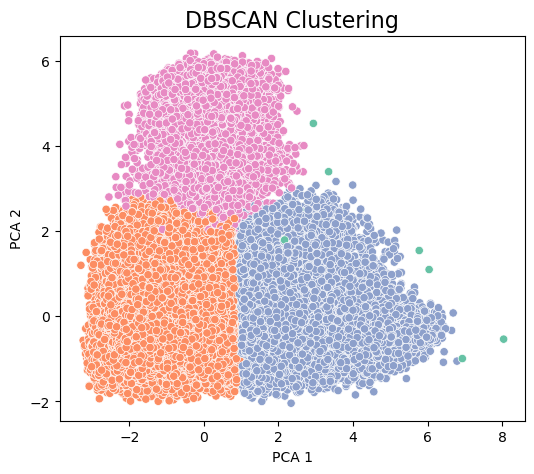

In [19]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data=data_pca, x='PCA 1', y='PCA 2', hue='mood_label_db', palette='Set2', legend=False)
plt.title('DBSCAN Clustering', fontsize=16)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

## Conclusion

By applying K-Means and DBSCAN to a generic Spotify songs dataset, we identified three distinct clusters representing different moods: chill, happy, and introspective. Both methods produced consistent results.